# Prostate cancer prediction using Convolutional Neuronal Networks (CNN):
Data:  tabular data (filtered RNAseq data from TCAG database for ML (Data preparation notebook) converted to images with the IGTD algorithms (from the IGTD_Tabular_data_to_images notebook)

Model: Concolutional neuronal networks (CNN)


This notebook contains:

-load packages, libraries and data.

- Vizualization of the generated the images:
- Plot the images generated with the IGDT script:
  -   Plot images from generated png files
  -   Plot images from generated txt (to check the images that will be used for CNN)

-load images from the txt files and generate the corresponding images paths and output labels

- create the torch sensor: images, labels and a list with file paths

-Prepare the loaders with the images and labels tensors and file paths

  - loaders in different ways:
      - split 80%-20% in training-validation set
         this was used to compare different CNN settings
      - split in 80% train, 10% validation and keep 10% as unseen for final testing. This split was used after finding an optimal CNN in order to have a final test for the model.

-Define different CNNs

-CNN training and testing with early stopping and saving the best model

-Code for final inference if the data was split in 3 loaders.

    

## Required packages, libraries and data

In [1]:
# Import require packages and libraries

import pandas as pd
import os
import numpy as np

import zipfile
import io

import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns


import tensorflow as tf
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch import optim

import random
import copy

# Set random seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)

# Set random seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)  # If using GPUs

# Additional steps for reproducibility in CUDA operations (if using GPUs)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


from sklearn.metrics import confusion_matrix,confusion_matrix,classification_report
from sklearn.model_selection import ParameterGrid


from google.colab import files

In [2]:
# open PRAD_ML_df_gene_names.csv
# file was generated in the Data preparation notebook


uploaded = files.upload()


Saving PRAD_ML_df_gene_names.csv to PRAD_ML_df_gene_names.csv


In [3]:
# upload data.zip
# data.zip is the compressed data with the results/output of the IGTD tabular image conversion generated from IGTD notebook
# in Folder: Results/Table_To_image_conversion/Results_IGTD_PRAD_euclidean/data.zip
#
uploaded = files.upload()

Saving data.zip to data.zip


In [4]:

# Assuming the uploaded file is named 'data.zip'
zip_file = io.BytesIO(uploaded['data.zip'])
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/data')  # Extract to a specific directory


In [5]:
# Import the example data and linearly scale each feature so that its minimum and maximum values are 0 and 1, respectively.The table used to generate the files and has the information-sample-condition:
data = pd.read_csv('/content/PRAD_ML_df_gene_names.csv', index_col=0)
data





,Condition,TNMD,AOC1,PDK4,ZMYND10,MYH13,SLC13A2,MATK,TFAP2B,TENM1,...,ENSG00000288047.1,ENSG00000288048.1,ENSG00000288060.1,ENSG00000288086.1,ENSG00000288097.1,ENSG00000288101.1,ENSG00000288104.1,ENSG00000288172.1,ENSG00000288547.3,ENSG00000288658.1
unstranded_2fa8c89c-893e-465a-aeb5-e3fb81a200c7.rna_seq.augmented_star_gene_counts.tsv,1,15.966137,865.532686,3723.471197,31.091951,0.840323,0.840323,874.776239,0.000000,715.955193,...,0.000000,35.293566,0.000000,5.041938,0.840323,3.361292,1.680646,0.000000,52.940349,0.000000
unstranded_288d2dc8-9fb3-4164-8e6a-cee107d11404.rna_seq.augmented_star_gene_counts.tsv,1,11.725003,34.002509,1224.090334,69.177519,0.000000,1.172500,315.402586,68.005019,1279.197849,...,0.000000,16.415004,2.345001,8.207502,0.000000,0.000000,5.862502,0.000000,22.277506,2.345001
unstranded_7b97885a-f365-4f11-8f35-9bf17a7344b5.rna_seq.augmented_star_gene_counts.tsv,1,1.597117,251.545950,1652.217685,46.316397,8.784144,3.194234,528.645775,1.597117,177.280003,...,0.000000,0.798559,1.597117,0.000000,0.000000,0.000000,3.194234,0.000000,22.359640,0.798559
unstranded_e32fc401-5ddd-4dfc-8be4-8d4072a080c3.rna_seq.augmented_star_gene_counts.tsv,1,4.584119,51.342133,150.359103,257.627488,2.750471,8.251414,110.935680,8.251414,16160.853136,...,1.833648,6.417767,23.837419,0.000000,0.916824,0.000000,106.351561,0.000000,5.500943,7.334590
unstranded_16eca87b-206a-4c2d-8ab7-f8c2fdb51b0e.rna_seq.augmented_star_gene_counts.tsv,1,2.606933,196.388934,13978.373392,48.662745,0.868978,0.000000,146.857211,2.606933,78.207982,...,0.000000,21.724440,2.606933,0.000000,0.000000,0.000000,4.344888,0.000000,92.980601,0.868978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
unstranded_422d5778-bfe0-4e2f-b254-2a753c777686.rna_seq.augmented_star_gene_counts.tsv,0,362.026157,85.928388,359838.505069,23.947256,7.043310,8271.663796,30.990566,153.544168,209.890652,...,14.086621,390.199399,0.000000,7.043310,8.451973,0.000000,1.408662,16.903945,2842.680099,177.491423
unstranded_60028d9d-c8e5-4c4e-a75c-cc3df6f2eea1.rna_seq.augmented_star_gene_counts.tsv,0,37.214004,5730.956592,877.946703,26.581431,0.000000,0.759469,30.378779,0.759469,841.492169,...,0.759469,15.948859,0.000000,5.316286,0.000000,0.000000,3.037878,0.000000,12.910981,0.000000
unstranded_2c022016-756e-4cbf-9baa-dab196b6e715.rna_seq.augmented_star_gene_counts.tsv,0,15.963598,27217.934445,12411.697379,17.959048,0.000000,9.312099,67.845291,1.330300,1197.934994,...,1.330300,24.610547,0.000000,9.312099,0.665150,0.665150,0.000000,0.000000,21.949947,2.660600
unstranded_998581d3-8fdc-4f4a-92cd-d98fc0f910bc.rna_seq.augmented_star_gene_counts.tsv,0,501.478180,7.975796,33270.036453,41.872930,0.000000,6171.272232,24.924363,121.630891,56.827547,...,48.851751,447.641556,0.000000,0.996975,26.918312,0.000000,0.996975,8.972771,2408.690422,280.149838


In [6]:
Output_names = ['Normal Tissue (0)','Primary Tumor (1)', ]
features = data.columns[1:].tolist()
#print(features)
#print(len(features))

# create a data frame with the sample names and conditions for use as y labels

Condition_df = data.iloc[:,:1]
Condition_df
print(Condition_df.columns)


Index(['Condition'], dtype='object')


In [7]:
Condition_df

,Condition
unstranded_2fa8c89c-893e-465a-aeb5-e3fb81a200c7.rna_seq.augmented_star_gene_counts.tsv,1
unstranded_288d2dc8-9fb3-4164-8e6a-cee107d11404.rna_seq.augmented_star_gene_counts.tsv,1
unstranded_7b97885a-f365-4f11-8f35-9bf17a7344b5.rna_seq.augmented_star_gene_counts.tsv,1
unstranded_e32fc401-5ddd-4dfc-8be4-8d4072a080c3.rna_seq.augmented_star_gene_counts.tsv,1
unstranded_16eca87b-206a-4c2d-8ab7-f8c2fdb51b0e.rna_seq.augmented_star_gene_counts.tsv,1
...,...
unstranded_422d5778-bfe0-4e2f-b254-2a753c777686.rna_seq.augmented_star_gene_counts.tsv,0
unstranded_60028d9d-c8e5-4c4e-a75c-cc3df6f2eea1.rna_seq.augmented_star_gene_counts.tsv,0
unstranded_2c022016-756e-4cbf-9baa-dab196b6e715.rna_seq.augmented_star_gene_counts.tsv,0
unstranded_998581d3-8fdc-4f4a-92cd-d98fc0f910bc.rna_seq.augmented_star_gene_counts.tsv,0


# Plot images from png generated files

Image Path: /content/data/data/_unstranded_b1467d5b-e034-4eb3-920f-fc6256ec3ce7.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_eed6ab73-90a3-4b63-9d82-8ae99f60c92d.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_c6b20bb4-cb04-4a59-8b66-211b787f8950.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_a3320ee3-e016-49c7-bbba-395240538ff7.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_ba632c2b-9b5a-434b-967a-863d3516fe24.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_673ef155-1bba-466d-92b4-cecb4121946e.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_ff2ba139-f4fb-43a7-8f9d-4a33c94e0381.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_3904bb4b-ef66-45fc-8030-c7e3a4daf22b.rna_seq.augmented

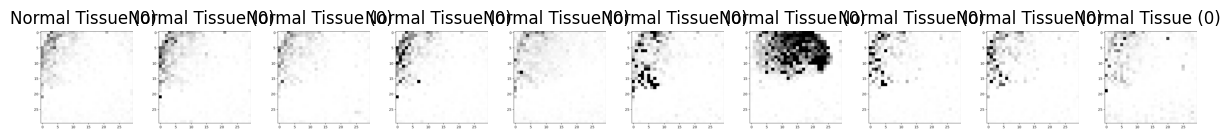

Image Path: /content/data/data/_unstranded_2fa8c89c-893e-465a-aeb5-e3fb81a200c7.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_288d2dc8-9fb3-4164-8e6a-cee107d11404.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_7b97885a-f365-4f11-8f35-9bf17a7344b5.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_e32fc401-5ddd-4dfc-8be4-8d4072a080c3.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_16eca87b-206a-4c2d-8ab7-f8c2fdb51b0e.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_328247b9-0404-48e2-8ee7-2c3afc12af6b.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_87b68e89-fab0-431d-a99b-04468de6a4a8.rna_seq.augmented_star_gene_counts.tsv_image.png
Image Path: /content/data/data/_unstranded_c5e68a3a-8343-4021-9efb-16d960f33bca.rna_seq.augmented

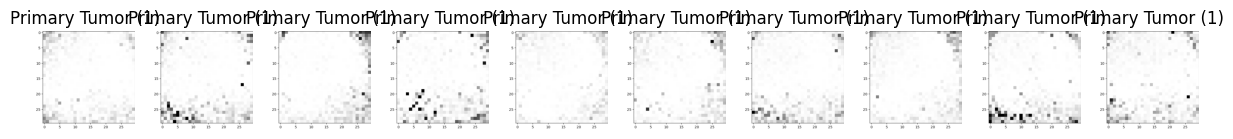

In [10]:
# plot few of the  generated images:

def plot_images(image_folder, df, condition_label, num_images=10):
    # Filter DataFrame based on condition label
    condition_df = df[df['Condition'] == condition_label].head(num_images)

    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, (sample_id, row) in enumerate(condition_df.iterrows()):
        # Add "_image" suffix to sample_id
        sample_id = f"_{sample_id}_image"

        # Construct image path
        image_path = os.path.join(image_folder, f"{sample_id}.png")

        print("Image Path:", image_path)  # Debug output

        # Check if image file exists
        if os.path.exists(image_path):
            image = Image.open(image_path)
            axes[i].imshow(image)
            if condition_label == 0:
              title = Output_names[0]
            else:
              title = Output_names[1]
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            print(f"Image file not found for sample ID: {sample_id}")

    #plt.tight_layout()
    plt.show()

# Assuming image folder contains the image files and df is your DataFrame
image_folder = '/content/data/data'
df = Condition_df

# Plot a few examples from condition 0 and condition 1
plot_images(image_folder, df, condition_label=0)
plot_images(image_folder, df, condition_label=1)


# Plot images from generated txt files

Text File Path: /content/data/data/_unstranded_b1467d5b-e034-4eb3-920f-fc6256ec3ce7.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_eed6ab73-90a3-4b63-9d82-8ae99f60c92d.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_c6b20bb4-cb04-4a59-8b66-211b787f8950.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_a3320ee3-e016-49c7-bbba-395240538ff7.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_ba632c2b-9b5a-434b-967a-863d3516fe24.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)


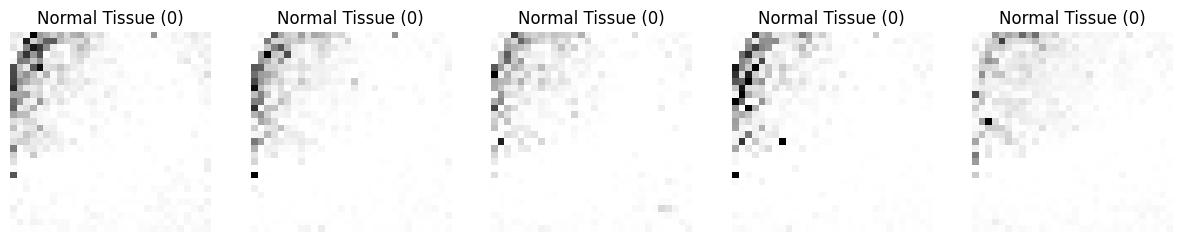

Text File Path: /content/data/data/_unstranded_2fa8c89c-893e-465a-aeb5-e3fb81a200c7.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_288d2dc8-9fb3-4164-8e6a-cee107d11404.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_7b97885a-f365-4f11-8f35-9bf17a7344b5.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_e32fc401-5ddd-4dfc-8be4-8d4072a080c3.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)
Text File Path: /content/data/data/_unstranded_16eca87b-206a-4c2d-8ab7-f8c2fdb51b0e.rna_seq.augmented_star_gene_counts.tsv_data.txt
(30, 30)


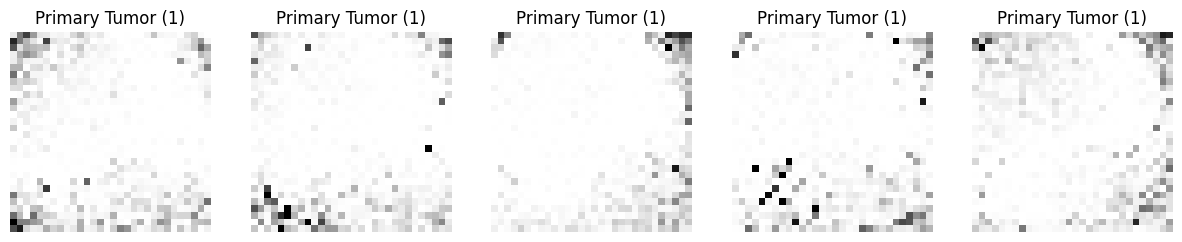

In [ ]:
# Function to plot images from the generated txt files in the IGDT notebook

def plot_images_txt(image_folder, df, condition_label, num_images=5):
    # Filter DataFrame based on condition label
    condition_df = df[df['Condition'] == condition_label].head(num_images)

    # Plot images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    for i, (sample_id, row) in enumerate(condition_df.iterrows()):
        # Read image path from text file
        image_file_path = os.path.join(image_folder, f"_{sample_id}_data.txt")

        print("Text File Path:", image_file_path)  # Debug output

        # Check if text file exists
        if os.path.exists(image_file_path):
            # Read pixel values from text file

            np_file = np.loadtxt(image_file_path)
            print (np_file.shape)


            # Display image
            axes[i].imshow(np_file, cmap = 'gray_r')
            if condition_label == 0:
              title = Output_names[0]
            else:
              title = Output_names[1]
            axes[i].set_title(title)
            axes[i].axis('off')
        else:
            print(f"Text file not found for sample ID: {sample_id}")

    plt.show()

# Assuming image folder contains text files with image paths and df is your DataFrame
image_folder = '/content/data/data'  # Update with the corresponding image folder path
df = Condition_df  # Update with your DataF


# Plot a few examples from condition 0 and condition 1
plot_images_txt(image_folder, df, condition_label=0)
plot_images_txt(image_folder, df, condition_label=1)

In [ ]:
# create a funtion to load the images
def load_images(image_folder, df):
    images = []
    labels = []
    file_paths = []
    for sample_id, row in df.iterrows():

        # Add "_image" suffix to sample_id
        sample_id = f"_{sample_id}_image"
        # Construct image path
        image_path = os.path.join(image_folder, f"{sample_id}.png")

    # Check if image file exists
        if os.path.exists(image_path):

        # Construct image path
            image_path = os.path.join(image_folder, f"{sample_id}.png")
        # Load image
            image = Image.open(image_path)
        # Preprocess image (e.g., resize, convert to array, normalize)
            image = preprocess_image(image)
        # Add image to list
            images.append(image)
        # Add label to list
            labels.append(row['Condition'])  # Assuming 'Condition' column contains labels
        # Add file path to list
            file_paths.append(image_path)

        else:
            print(f"Image file not found for sample ID: {sample_id}")


    return np.array(images), labels, file_paths

# funtion convert images to np arrays (normalization was not necessary, size can also be change, but we have the actual size 30,30)
def preprocess_image(image):
    # Resize image to desired size
    #image = image.resize((30, 30))  # Example size, adjust as needed
    # Convert image to numpy array
    image = np.array(image)
     #Normalize pixel values to range [0, 1]
    #image = image / 255.0
    return image


# Load images(np.array), labels(list), and file paths(list)
images, labels, file_paths = load_images(image_folder, df)

#print(images)

In [ ]:
print(labels)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print(file_paths)

['/content/data/data/_unstranded_2fa8c89c-893e-465a-aeb5-e3fb81a200c7.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_288d2dc8-9fb3-4164-8e6a-cee107d11404.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_7b97885a-f365-4f11-8f35-9bf17a7344b5.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_e32fc401-5ddd-4dfc-8be4-8d4072a080c3.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_16eca87b-206a-4c2d-8ab7-f8c2fdb51b0e.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_328247b9-0404-48e2-8ee7-2c3afc12af6b.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_87b68e89-fab0-431d-a99b-04468de6a4a8.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_c5e68a3a-8343-4021-9efb-16d960f33bca.rna_seq.augmented_star_gene_counts.tsv_image.png', '/content/data/data/_unstranded_0d355d6

# Load images from txt files and generate corresponding labels and file paths

In [42]:
# Assuming image folder contains text files with image paths and df is your DataFrame
image_folder = '/content/data/data'  # Update with your image folder path
df = Condition_df  # Update with your DataF

# create a funtion to load the images

def load_images_txt(image_folder, df):
    images = []
    labels = []
    file_paths = []
    for sample_id, row in df.iterrows():

        # Add "_image" suffix to sample_id
        sample_id = f"_{sample_id}_data"
        # Construct image path
        image_path = os.path.join(image_folder, f"{sample_id}.txt")

    # Check if image file exists
        if os.path.exists(image_path):


        # Load image
            image = np.loadtxt(image_path)

        # Reshape the image to add a channel dimension
            image = np.expand_dims(image, axis=-1)  # Assuming images are grayscale

        # Add image to list
            images.append(image)
        # Add label to list
            labels.append(row['Condition'])  # Assuming 'Condition' column contains labels
        # Add file path to list
            file_paths.append(image_path)

        else:
            print(f"Image file not found for sample ID: {sample_id}")

        # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

         # Move channel dimension to the correct position
    images = np.moveaxis(images, -1, 1)

    return images, labels, file_paths


# Load images(np.array), labels(list), and file paths(list)
images, labels, file_paths = load_images_txt(image_folder, df)

#print(images)

# Create the torch sensors
- Use images generated by reading the txt files (png files, have scales bars that can interfere with the training)

In [43]:
# make torch tensors in batches to reduce memory usage:


def batch_generator(images, labels, file_paths, batch_size):
    num_samples = len(images)
    for start_idx in range(0, num_samples, batch_size):
        end_idx = min(start_idx + batch_size, num_samples)
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]
        batch_file_paths = file_paths[start_idx:end_idx]
        yield batch_images, batch_labels, batch_file_paths

# Example usage:
images_tensor_list = []
labels_tensor_list = []
file_paths_list = []

batch_size = 32

# Iterate over batches
for batch_images, batch_labels, batch_file_paths in batch_generator(images, labels, file_paths, batch_size):
    # Convert batch_images, batch_labels, and batch_file_paths to tensors
    batch_images_tensor = torch.tensor(batch_images)
    batch_labels_tensor = torch.tensor(batch_labels)

    # Append to lists
    images_tensor_list.append(batch_images_tensor)
    labels_tensor_list.append(batch_labels_tensor)
    file_paths_list.append(batch_file_paths)

# Concatenate tensors along batch dimension
images_tensor = torch.cat(images_tensor_list, dim=0)
labels_tensor = torch.cat(labels_tensor_list, dim=0)




# Concatenate file paths into a single list
file_paths = [item for sublist in file_paths_list for item in sublist]


print(f'images_tensor shape: {images_tensor.shape}')
print(f'labels_tensor shape: {labels_tensor.shape}')
print(f'file path list lengh: {len(file_paths)}')


images_tensor shape: torch.Size([356, 1, 30, 30])
labels_tensor shape: torch.Size([356])
file path list lengh: 356


In [44]:
#print(images_tensor)
#print(labels_tensor)

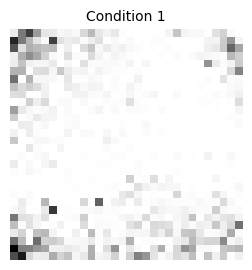

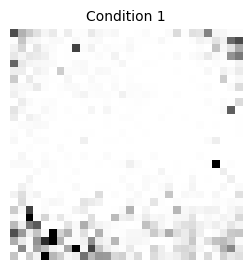

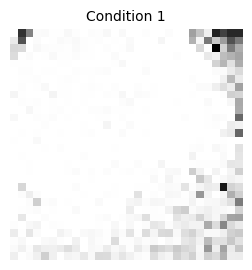

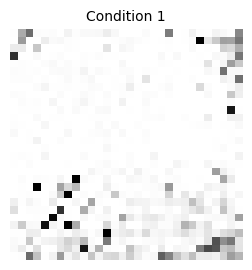

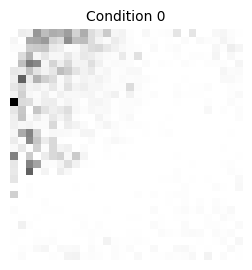

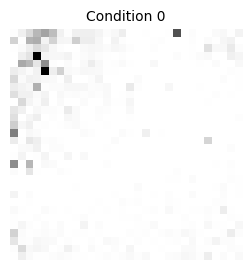

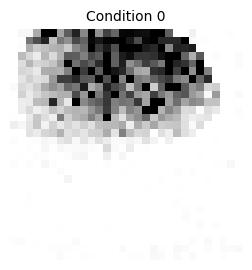

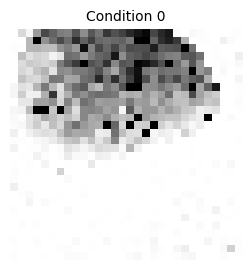

In [45]:
# Plot a few images from the generated txt tensors to check the conversion was ok:

visualize_indices = [0,1,2,3,353,352,354,355]
# Plot each selected image individually
for idx in visualize_indices:
    # Get image and label
    image_to_plot = images[idx][0]  # Extract the image data and remove the channel dimension
    label_to_plot = labels[idx]

    # Plot image
    plt.figure(figsize=(3, 3))
    plt.imshow(image_to_plot, cmap='gray_r', aspect='auto')
    plt.title(f'Condition {label_to_plot}', fontsize=10)
    plt.axis('off')  # Turn off axis
    plt.show()


# Prepare the loaders (normal)

In [ ]:
# normalized the images tensors and labels tensors, normalization was given worst results, probably because the counts are already normalized
# create float tensors
#images_tensor = images_tensor.float() / 255.0

#images_tensor = images_tensor.clone().detach().to(torch.float32)
#labels_tensor = labels_tensor.clone().detach().to(torch.float32)
# prepare the loadings:

# split the data set and create the loaders:

# use Dataset class provided by the torch.utils.data module, used as a base class for creating custom datasets in PyTorch.
# class: defines a custom dataset (RNAseqImageDataset) for handling Images of RNAseq data Takes three parameters during initialization: images, labels, and file_paths.

class RNAseqImageDataset(Dataset):
    def __init__(self, images_tensor, labels_tensor, file_paths):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor
        self.file_paths = file_paths

# returns the length of the dataset = the number of images.
    def __len__(self):
        return len(self.images_tensor)

# retrieves an item from the dataset based on its index (idx)
# returns a tuple : image, its label, and its file path.

    def __getitem__(self, idx):
        return self.images_tensor[idx], self.labels_tensor[idx], self.file_paths[idx]


# Normal loaders- split (80% train-20% validation)

In [ ]:


# Set size of training and validation sets (80 % train, 20 % test)

train_size = int(0.8 * len(images_tensor))
test_size = len(images_tensor) - train_size

# Split the dataset into training and validation with random_split function from PyTorch.
# takes tuples (images, labels, and file paths) and the list with the sizes of the training and validation sets.

train_dataset, test_dataset = random_split(list(zip(images_tensor, labels_tensor, file_paths)), [train_size, test_size])


# create the loaders- using the Dataloader class from PyTorch
batch_size = 32

train_loader = DataLoader(dataset=RNAseqImageDataset(*zip(*train_dataset)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=RNAseqImageDataset(*zip(*test_dataset)), batch_size=batch_size, shuffle=False)

# strore data loaders as dictionaries
loaders = {'train': train_loader, 'test': test_loader}


# Check shape of the loaders:
#Assuming loaders is a dictionary containing the data loaders for train and test sets

# Check the shape of the first batch in the training loader
for images_tensor, labels_tensor, file_paths in loaders['train']:
    print("Images shape (first batch in training loader):", images_tensor.shape)
    print("Labels shape (training loader):", labels_tensor.shape)
    print("File paths (first batch in training loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

# Check the shape of the first batch in the test loader
for images_tensor, labels_tensor, file_paths in loaders['test']:
    print("Images shape (first batch in test loader):", images_tensor.shape)
    print("Labels shape (test loader):", labels_tensor.shape)
    print("File paths (first batch in test loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

Images shape (first batch in training loader): torch.Size([32, 1, 30, 30])
Labels shape (training loader): torch.Size([32])
File paths (first batch in training loader): ('/content/data/data/_unstranded_22200e14-44e6-4660-9289-62ad3db1df7b.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_7e6e77ec-acdb-4498-b556-486ff71efa63.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_c295bf2b-7e70-40fb-8af7-87616394692b.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_fcb8b926-8d57-403d-9c86-e4f70718fc48.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_08159a41-8f71-42a3-94a7-c4f9579e5b34.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_55b84289-acf0-4385-8b69-e5bd597130ae.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_cb7e1044-9796-497d-8f96-7ca249fbc62e.rna_seq.augmented_star_gene_counts.tsv_data.txt

In [ ]:
# Assuming loaders is a dictionary containing DataLoader objects
for i, (images_tensor, labels_tensor, file_paths) in enumerate(loaders['test']):
    print(f"Batch {i + 1} - Images: {images_tensor.shape}, Labels: {labels_tensor}, File Paths: {file_paths}")

    # Print a few examples from the batch
    for j in range(min(5, len(images_tensor))):  # Print details for up to 5 examples in each batch
        print(f"Example {j + 1}: Label - {labels_tensor[j].item()}, File Path - {file_paths[j]}")

    # Break the loop after a few batches for brevity
    if i == 2:
        break

Batch 1 - Images: torch.Size([32, 1, 30, 30]), Labels: tensor([1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 1, 1, 1, 0, 0, 1]), File Paths: ('/content/data/data/_unstranded_b0d86c72-de96-492a-8303-e536e925b94e.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_748df5d4-527b-49d9-8093-c326cb61a015.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_bc91971d-1711-4230-a49c-b771da52e97f.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_45950878-b6ec-4fcd-b4d4-fb7f6cde5a63.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_2853dc01-4c51-404a-9639-f3138fb65051.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_90436346-519d-4fb1-bb5e-2684a1618e14.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_d366a38e-1af8-4840-93a9-7848b461449d.rna_seq.augmented_star_gene_counts.

# Prepare de Loaders with data augmentation (80% train-20% validation) (makes model worst)


In [48]:


# Define your data augmentation transformations
# You can add or modify transformations as needed
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
])

# Modify the RNAseqImageDataset class to apply transformations to the images
class RNAseqImageDataset_Aument(Dataset):
    def __init__(self, images_tensor, labels_tensor, file_paths, transform=None):
        self.images_tensor = images_tensor
        self.labels_tensor = labels_tensor
        self.file_paths = file_paths
        self.transform = transform

    def __len__(self):
        return len(self.images_tensor)

    def __getitem__(self, idx):
        image = self.images_tensor[idx]
        label = self.labels_tensor[idx]
        file_path = self.file_paths[idx]

        if self.transform:
            image = self.transform(image)

        return image, label, file_path


# Set size of training and validation sets (80 % train, 20 % test)
train_size = int(0.8 * len(images_tensor))
test_size = len(images_tensor) - train_size

# Split the dataset into training and validation sets
train_dataset, test_dataset = random_split(list(zip(images_tensor, labels_tensor, file_paths)), [train_size, test_size])

# Create DataLoader instances with data augmentation
train_loader = DataLoader(dataset=RNAseqImageDataset_Aument(*zip(*train_dataset), transform=data_transforms),
                          batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=RNAseqImageDataset_Aument(*zip(*test_dataset), transform=data_transforms),
                         batch_size=batch_size, shuffle=False)

# Store data loaders as dictionaries
loaders_augmented = {'train': train_loader, 'test': test_loader}


In [49]:
# Check shape of the loaders:
#Assuming loaders is a dictionary containing the data loaders for train and test sets

# Check the shape of the first batch in the training loader
for images_tensor, labels_tensor, file_paths in loaders_augmented['train']:
    print("Images shape (first batch in training loader):", images_tensor.shape)
    print("Labels shape (training loader):", labels_tensor.shape)
    print("File paths (first batch in training loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

# Check the shape of the first batch in the test loader
for images_tensor, labels_tensor, file_paths in loaders_augmented['test']:
    print("Images shape (first batch in test loader):", images_tensor.shape)
    print("Labels shape (test loader):", labels_tensor.shape)
    print("File paths (first batch in test loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

Images shape (first batch in training loader): torch.Size([32, 1, 30, 30])
Labels shape (training loader): torch.Size([32])
File paths (first batch in training loader): ('/content/data/data/_unstranded_51258abc-7e84-488f-bf90-0db3a84215f1.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_54498dee-7413-4b90-971a-2abd1d9aa5d2.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_dc49b777-0be6-430e-ab33-c0aa9f6264ee.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_b8d19fd2-bc0b-4e1a-b38d-f30191eef786.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_9975ae8f-09f2-4343-9281-cbe13c775dca.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_5316c66f-3cc5-4273-bc01-7825ac5bcb87.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_59c56aa9-a5e0-4685-a0b5-7dcb4d4ccc40.rna_seq.augmented_star_gene_counts.tsv_data.txt

In [51]:
# Assuming loaders is a dictionary containing DataLoader objects
for i, (images_tensor, labels_tensor, file_paths) in enumerate(loaders_augmented['test']):
    print(f"Batch {i + 1} - Images: {images_tensor.shape}, Labels: {labels_tensor}, File Paths: {file_paths}")

    # Print a few examples from the batch
    for j in range(min(5, len(images_tensor))):  # Print details for up to 5 examples in each batch
        print(f"Example {j + 1}: Label - {labels_tensor[j].item()}, File Path - {file_paths[j]}")

    # Break the loop after a few batches for brevity
    if i == 6:
        break

Batch 1 - Images: torch.Size([32, 1, 30, 30]), Labels: tensor([1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), File Paths: ('/content/data/data/_unstranded_87b68e89-fab0-431d-a99b-04468de6a4a8.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_3312f92e-ca79-42b3-8430-918d5f5ae528.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_36686dd6-2f3e-4950-9fbb-d1952d3bd5fd.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_3b54fd87-6631-4ae9-b303-bc14ffa51685.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_060957c4-19f6-4a12-8f45-67746f317398.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_2c022016-756e-4cbf-9baa-dab196b6e715.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_c5fca91d-25ec-443e-bb4a-3b3064d7c180.rna_seq.augmented_star_gene_counts.

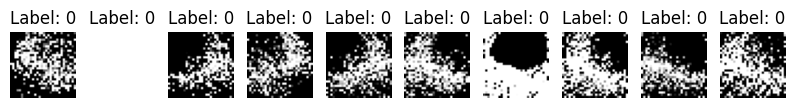

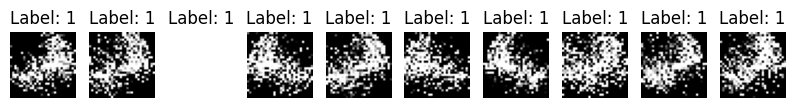

In [52]:

# Function to display images
def show_images(images, labels):
    plt.figure(figsize=(10, 4))
    for i in range(len(images)):
        plt.subplot(2, 10, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)), cmap="gray_r")  # Transpose the image tensor to (height, width, channels) for display
        plt.title(f"Label: {labels[i].item()}")
        plt.axis('off')
    plt.show()

# Get a batch of images and labels from the loader
images_with_label_0 = []
images_with_label_1 = []
labels_with_label_0 = []
labels_with_label_1 = []

for images, labels, _ in loaders_augmented['train']:
    for img, label in zip(images, labels):
        if label == 0 and len(images_with_label_0) < 10:
            images_with_label_0.append(img)
            labels_with_label_0.append(label)
        elif label == 1 and len(images_with_label_1) < 10:
            images_with_label_1.append(img)
            labels_with_label_1.append(label)
    if len(images_with_label_0) >= 10 and len(images_with_label_1) >= 10:
        break  # Break after collecting 10 images with label 0 and 10 images with label 1

# Display images with label 0
show_images(images_with_label_0, labels_with_label_0)

# Display images with label 1
show_images(images_with_label_1, labels_with_label_1)


# Prepare the loaders but splitting into 3 sets (train 80%, test (validation)10%, test (unseen data) 10% to use for final validation
- Note: run the RNAseqImageDataSet Class in the loaders normal script first

In [ ]:


# Set sizes for training, validation, and test sets
train_size = int(0.8 * len(images_tensor))
validation_size = int(0.1 * len(images_tensor))
test_size = len(images_tensor) - train_size - validation_size

# Split the dataset into training, validation, and test sets
train_dataset, validation_dataset, test_dataset = random_split(
    list(zip(images_tensor, labels_tensor, file_paths)),
    [train_size, validation_size, test_size]
)

# Create data loaders for training, validation, and test sets
train_loader = DataLoader(dataset=RNAseqImageDataset(*zip(*train_dataset)), batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=RNAseqImageDataset(*zip(*validation_dataset)), batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=RNAseqImageDataset(*zip(*test_dataset)), batch_size=batch_size, shuffle=False)

# Store data loaders as dictionaries
loaders_split_3 = {'train': train_loader, 'validation': validation_loader, 'test': test_loader}



# Check shape of the loaders:
#Assuming loaders is a dictionary containing the data loaders for train and test sets

# Check the shape of the first batch in the training loader
for images_tensor, labels_tensor, file_paths in loaders_split_3['train']:
    print("Images shape (first batch in training loader):", images_tensor.shape)
    print("Labels shape (training loader):", labels_tensor.shape)
    print("File paths (first batch in training loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

# Check the shape of the first batch in the test loader
for images_tensor, labels_tensor, file_paths in loaders_split_3['test']:
    print("Images shape (first batch in test loader):", images_tensor.shape)
    print("Labels shape (test loader):", labels_tensor.shape)
    print("File paths (first batch in test loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

# Check the shape of the first batch in the val loader
for images_tensor, labels_tensor, file_paths in loaders_split_3['validation']:
    print("Images shape (first batch in validation loader):", images_tensor.shape)
    print("Labels shape (test loader):", labels_tensor.shape)
    print("File paths (first batch in validation loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch


Images shape (first batch in training loader): torch.Size([32, 1, 30, 30])
Labels shape (training loader): torch.Size([32])
File paths (first batch in training loader): ('/content/data/data/_unstranded_5405da4d-a314-4942-ace8-695b248f1e26.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_fbae2522-a784-4273-8219-6d5cfb335ef7.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_2cacbe10-481e-42d7-8b01-5ad9537ed2c1.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_22f9e8d8-056f-46bc-b981-747b9d5c0ecb.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_9c77256c-e9e7-49fd-992d-bf1df85d2a63.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_c3040097-9298-4847-8ba5-03a1c94769d5.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_3063073a-b4df-4017-b15a-bad1c22d3a41.rna_seq.augmented_star_gene_counts.tsv_data.txt

In [ ]:
# Assuming loaders is a dictionary containing DataLoader objects
for i, (images_tensor, labels_tensor, file_paths) in enumerate(loaders_split_3['test']):
    print(f"Batch {i + 1} - Images: {images_tensor.shape}, Labels: {labels_tensor}, File Paths: {file_paths}")

    # Print a few examples from the batch
    for j in range(min(5, len(images_tensor))):  # Print details for up to 5 examples in each batch
        print(f"Example {j + 1}: Label - {labels_tensor[j].item()}, File Path - {file_paths[j]}")

    # Break the loop after a few batches for brevity
    if i == 2:
        break

Batch 1 - Images: torch.Size([32, 1, 30, 30]), Labels: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1]), File Paths: ('/content/data/data/_unstranded_addee8f0-f553-4d78-abb1-d3f50d52386a.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_69696d6d-70fa-430d-982b-8be9fc0f720b.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_1a4bad69-1437-42c2-996e-8afa606cb40b.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_dc49b777-0be6-430e-ab33-c0aa9f6264ee.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_f0b8075e-83ef-4ac9-a30d-8c1f9a18668e.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_998581d3-8fdc-4f4a-92cd-d98fc0f910bc.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_d1338761-2196-4fd3-8b50-f2efb8a3f850.rna_seq.augmented_star_gene_counts.

In [ ]:
# Assuming loaders is a dictionary containing DataLoader objects
for i, (images_tensor, labels_tensor, file_paths) in enumerate(loaders_split_3['train']):
    print(f"Batch {i + 1} - Images: {images_tensor.shape}, Labels: {labels_tensor}, File Paths: {file_paths}")

    # Print a few examples from the batch
    for j in range(min(5, len(images_tensor))):  # Print details for up to 5 examples in each batch
        print(f"Example {j + 1}: Label - {labels_tensor[j].item()}, File Path - {file_paths[j]}")

    # Break the loop after a few batches for brevity
    if i == 4:
        break

Batch 1 - Images: torch.Size([32, 1, 30, 30]), Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1]), File Paths: ('/content/data/data/_unstranded_d6ab40a9-8c37-4b1e-90d2-f431ef00ee68.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_03398018-84f0-4d18-80b2-bcec909f08a9.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_3063073a-b4df-4017-b15a-bad1c22d3a41.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_aa5bb7ab-a680-4d30-b58e-ed2c8a4cff50.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_15b903cc-587c-4e85-96d7-c699e525601d.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_e32fc401-5ddd-4dfc-8be4-8d4072a080c3.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_d1880019-5bce-47c7-8f0a-954f5fa9ccc9.rna_seq.augmented_star_gene_counts.

# Try Differente CNNs:






In [ ]:
# we get loaders_cnn from the saved original loaders that we do not pass to the Cnn
#loaders_cnn = copy.deepcopy(loaders) # normal loaders
#loaders_cnn = copy.deepcopy(loaders_augmented) # loaders with data augmentation
loaders_cnn =copy.deepcopy(loaders_split_3) # loaders when data was split in 3 to leave 10% unseen as test.


In [ ]:
# Check the shape of the first batch in the training loader
for images_tensor, labels_tensor, file_paths in loaders_cnn['train']:
    print("Images shape (first batch in training loader):", images_tensor.shape)
    print("Labels shape (training loader):", labels_tensor.shape)
    print("File paths (first batch in training loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch

# Check the shape of the first batch in the test loader
for images_tensor, labels_tensor, file_paths in loaders_cnn['test']:
    print("Images shape (first batch in test loader):", images_tensor.shape)
    print("Labels shape (test loader):", labels_tensor.shape)
    print("File paths (first batch in test loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch


Images shape (first batch in training loader): torch.Size([32, 1, 30, 30])
Labels shape (training loader): torch.Size([32])
File paths (first batch in training loader): ('/content/data/data/_unstranded_2fa8c89c-893e-465a-aeb5-e3fb81a200c7.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_2fbf53f9-fb24-4afd-b643-a2b132994f87.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_588e9230-8412-4648-9f87-a6d7676df3b6.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_10b332c1-5e60-4a3a-8f82-402892ea832d.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_fb867d17-df3f-428f-a9e4-28ca204be1bf.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_3312f92e-ca79-42b3-8430-918d5f5ae528.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_bc91971d-1711-4230-a49c-b771da52e97f.rna_seq.augmented_star_gene_counts.tsv_data.txt

### **PV4-1-2_Relu**: CNN 4 Convolutional layers, 1 maxpooling, 2 linear layers, Binary Cross-Entropy Loss

Hidden Layers: RELU

Output layer : Sigmoid


In [ ]:
#Hyperparameters: (from grid search " early stopping" : lr=0.005, epochs=14-16 / lr= 0.008, epochs=12-15)
num_epochs = 17
learning_rate = 0.0002
#learning_rate =0.008
#learning_rate =0.01
#num_epochs = 13


In [ ]:
# Define the CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1) #parameters: input channels (=1), output channels (=16), kernel size
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 32)   #Adjusted input size based on the output of conv4 =output layer conv4 = 32, 64, 8, 4 after poolling, calculates the total number of features (or neurons) in the flattened output, which serves as the input size to the fully connected layer.
        self.fc2 = nn.Linear(32, 1)  # Output layer with 1 neuron for binary classification
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation function

    def forward(self, x, loaders_cnn):
        x= x.float()
        #print(f'x-size: {x.size()}')
        x = F.relu(self.conv1(x))
        #print(f' size conv1 {x.size()}') # torch.Size([32, 16, 30, 30])) (batch size, channels, height, width)
        x = F.relu(self.conv2(x))
        #print(f' size conv2 {x.size()}') # ([32, 32, 15, 15]])
        x = F.relu(self.conv3(x))
        #print(f' size conv3 {x.size()}') # ([[32, 32, 8, 8]))
        x = F.relu(self.conv4(x))
        #print(f' size conv4 {x.size()}') # ([[32, 64, 4, 4]))
        x = F.max_pool2d(x, 2)
        #print(f' size conV after pooling {x.size()}') # ([[32, 64, 2, 2]))
        x = x.view(-1, 64 * 2 * 2)         # Purpose is to flatten the 4d tensor to 1d, so it can be fed into FC layer, flattens the number of features/neurons (64 channels, and after max pooling,  height reduced to 8 and the width to 4 )
        #print(f' size xview {x.size()}') #  ([32, 2048]) # batch size, features
        x = F.relu(self.fc1(x))
        #print(f' size fc1 {x.size()}') #([32, 32])
        output = self.sigmoid(self.fc2(x))
        #print(f' size output after sigmoid {output.size()}')
        #print(output) # if we print we can see that is a 0-1 value with probabilities

        return output

# Iniciate the model
cnn = CNN()

# define loss
loss_func = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
loss_func

# define optimizer
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0002
    maximize: False
    weight_decay: 0
)

### **PV4-1-2-Tahn**: CNN 4 Convolutional layers, 1 maxpooling, 2 linear layers, Binary Cross_Entropy loss

*  Hidden layers: Tahn activation
*  Output layer: Sigmoid

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 2 * 2, 32)
        self.fc2 = nn.Linear(32, 1)  # Output layer with 1 neuron for binary classification
        self.tanh = nn.Tanh()  # Tanh activation function

    def forward(self, x, loaders_cnn):
        x= x.float()
        x = self.tanh(self.conv1(x))
        #print(f' size conv1 {x.size()}') # torch.Size([32, 16, 128, 64])
        x = self.tanh(self.conv2(x))
        #print(f' size conv2 {x.size()}') # ([32, 16, 128, 64])
        x = self.tanh(self.conv3(x))
        #print(f' size conv3 {x.size()}') # ([32, 32, 32, 16])
        x = self.tanh(self.conv4(x))
        #print(f' size conv4 {x.size()}') # ([32, 64, 16, 8])
        x = F.max_pool2d(x, 2)
        #print(f' size conV after pooling {x.size()}') # ([32, 64, 8, 4])
        x = x.view(-1, 64 * 2 * 2)
        #print(f' size xview {x.size()}') #  ([32, 2048])
        x = self.tanh(self.fc1(x))
        #print(f' size fc1 {x.size()}') #([32, 32])
        output = torch.sigmoid(self.fc2(x))
        #print(f' size output after sigmoid {output.size()}')
        #print(output) # if we print we can see that is a 0-1 value with probabilities

        return output


# Iniciate the model
cnn = CNN()

# define loss
loss_func = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
loss_func

# define optimizer

optimizer = optim.Adam(cnn.parameters(), lr = learning_rate)
optimizer

# Define optimizer
optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)

optimizer

# Train and Evaluate the CNNs

In [ ]:
classes = ["Solid Tissue Normal", "Primary Tumor"]  # Set your class labels for confusion matrix display

# create a funtion to train and evaluate the CNN performance in the validation set
def train_and_evaluate_cnn_2(model, loaders_cnn, learning_rate, patience=12):
    loss_func = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_accuracy = 0.0
    best_epoch = 0
    no_improvement_count = 0

    train_losses = []
    test_losses = []
    accuracies = []
    confusion_matrices = []
    classification_reports = []
    #correct_infos =[]
    #incorrect_infos =[]

    for epoch in range(1000):  # Set a high value for num_epochs
        # Training
        model.train()
        train_loss = 0.0
        for images, labels, file_paths in loaders_cnn['train']:
            optimizer.zero_grad()
            outputs = model(images,loaders_cnn)
            outputs = outputs.squeeze(dim=1)
            loss = loss_func(outputs, labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(loaders_cnn['train'])
        train_losses.append(avg_train_loss)

        # Testing
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        correct_info = [] # appended data for all batches in this epoch
        incorrect_info = []

        y_true_epoch = []
        y_pred_epoch = []

        with torch.no_grad():
            for images, labels, file_paths in loaders_cnn['test']:
                outputs = model(images, loaders_cnn)
                outputs = outputs.squeeze(dim=1)
                loss = loss_func(outputs, labels.float())
                test_loss += loss.item()

                predicted = torch.round(outputs)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

              # append true and predicted labels for each batch
                y_true_epoch.extend(labels.tolist())
                y_pred_epoch.extend(predicted.tolist())

              # Check for correct and incorrect predictions, tuples containing the indexes, the images, predicted and true labels and images paths.
                correct_mask = predicted == labels
                cumulative_batch_size = labels.size(0) * i

                correct_info.extend([(cumulative_batch_size + j, images[j], predicted[j].item(), labels[j].item(), file_paths[j]) for j, is_correct in enumerate(correct_mask) if is_correct])
                incorrect_info.extend([(cumulative_batch_size + j, images[j], predicted[j].item(), labels[j].item(), file_paths[j]) for j, is_correct in enumerate(correct_mask) if not is_correct])


        avg_test_loss = test_loss / len(loaders_cnn['test'])
        test_losses.append(avg_test_loss)

        accuracy = 100 * correct / total
        accuracies.append(accuracy)

        print(f"Epoch [{epoch + 1}], Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_test_loss:.4f}, Accuracy in Validation set: {accuracy:.2f}%")

        # Check for early stopping
        if epoch > 0:
            if accuracies[-1] > best_accuracy:
                best_accuracy = accuracies[-1]
                best_epoch = epoch
                no_improvement_count = 0

                Best_correct_info = correct_info
                Best_incorrect_info =incorrect_info

                # Compute confusion matrix and classification report for the best epoch
                cm = confusion_matrix(y_true_epoch, y_pred_epoch)
                confusion_matrices.append(cm)
                classification_report_str = classification_report(y_true_epoch, y_pred_epoch)
                classification_reports.append(classification_report_str)

            else:
                no_improvement_count += 1

            if no_improvement_count >= patience:
                print(f'Early stopping at epoch {epoch + 1}. Best accuracy: {best_accuracy}')
                break

    # Plot the confusion matrix for the best epoch
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrices[-1], annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print the classification report for the best epoch
    print("Classification Report-Validation:")
    print(classification_reports[-1])

    return {
        'best_epoch': best_epoch + 1,
        'best_accuracy': best_accuracy,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'accuracies': accuracies,
        'confusion_matrices': confusion_matrices,
        'classification_reports': classification_reports,
        'Best_correct_info' : Best_correct_info,
        'Best_incorrect_info' :Best_incorrect_info
    }


RESUTS FOR LEARNING RATE: 0.0002
Epoch [1], Train Loss: 0.6139, Validation Loss: 0.4344, Accuracy in Validation set: 97.30%
Epoch [2], Train Loss: 0.4596, Validation Loss: 0.2573, Accuracy in Validation set: 97.30%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3], Train Loss: 0.3466, Validation Loss: 0.1835, Accuracy in Validation set: 100.00%
Epoch [4], Train Loss: 0.2520, Validation Loss: 0.1373, Accuracy in Validation set: 97.30%
Epoch [5], Train Loss: 0.1955, Validation Loss: 0.1272, Accuracy in Validation set: 94.59%
Epoch [6], Train Loss: 0.1714, Validation Loss: 0.1035, Accuracy in Validation set: 94.59%
Epoch [7], Train Loss: 0.1711, Validation Loss: 0.0795, Accuracy in Validation set: 94.59%
Epoch [8], Train Loss: 0.1629, Validation Loss: 0.0866, Accuracy in Validation set: 94.59%
Epoch [9], Train Loss: 0.1522, Validation Loss: 0.0846, Accuracy in Validation set: 94.59%
Epoch [10], Train Loss: 0.1461, Validation Loss: 0.0818, Accuracy in Validation set: 94.59%
Epoch [11], Train Loss: 0.1402, Validation Loss: 0.0908, Accuracy in Validation set: 94.59%
Epoch [12], Train Loss: 0.1327, Validation Loss: 0.0821, Accuracy in Validation set: 94.59%
Epoch [13], Train Loss: 0.1265, Validation Loss: 0.0739, Accuracy in Validation set: 9

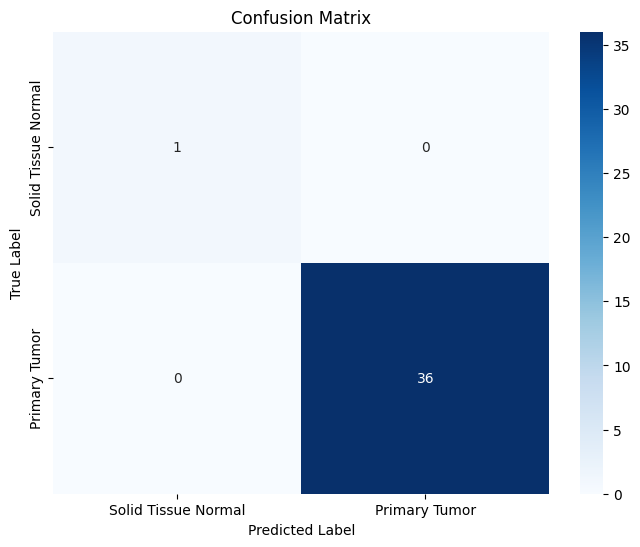

Classification Report-Validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        36

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Learning Rate: 0.0002, Best Accuracy: 100.0, Best Epoch: 3


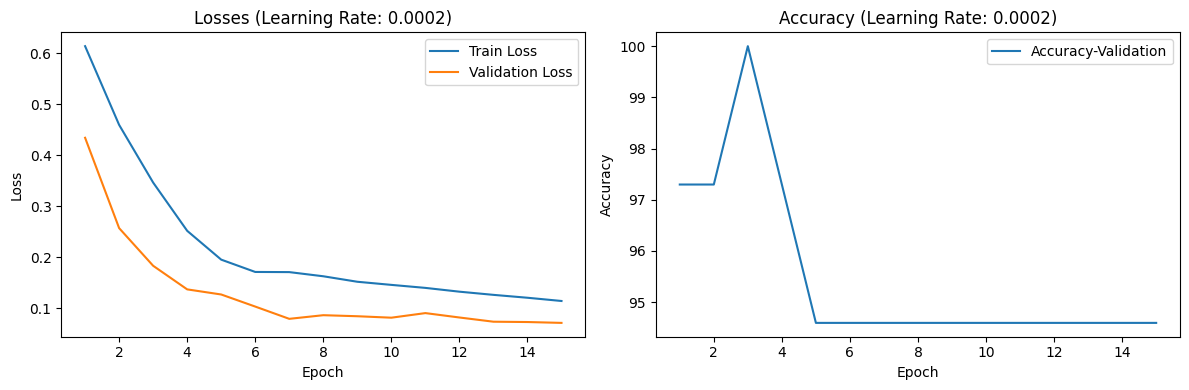


RESUTS FOR LEARNING RATE: 0.0001
Epoch [1], Train Loss: 0.5732, Validation Loss: 0.4635, Accuracy in Validation set: 97.30%
Epoch [2], Train Loss: 0.4535, Validation Loss: 0.3354, Accuracy in Validation set: 97.30%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [3], Train Loss: 0.3690, Validation Loss: 0.2376, Accuracy in Validation set: 100.00%
Epoch [4], Train Loss: 0.2982, Validation Loss: 0.1929, Accuracy in Validation set: 97.30%
Epoch [5], Train Loss: 0.2362, Validation Loss: 0.1575, Accuracy in Validation set: 97.30%
Epoch [6], Train Loss: 0.1973, Validation Loss: 0.1270, Accuracy in Validation set: 94.59%
Epoch [7], Train Loss: 0.1766, Validation Loss: 0.1043, Accuracy in Validation set: 94.59%
Epoch [8], Train Loss: 0.1640, Validation Loss: 0.0990, Accuracy in Validation set: 94.59%
Epoch [9], Train Loss: 0.1613, Validation Loss: 0.0920, Accuracy in Validation set: 94.59%
Epoch [10], Train Loss: 0.1593, Validation Loss: 0.0787, Accuracy in Validation set: 97.30%
Epoch [11], Train Loss: 0.1488, Validation Loss: 0.0882, Accuracy in Validation set: 94.59%
Epoch [12], Train Loss: 0.1437, Validation Loss: 0.0840, Accuracy in Validation set: 94.59%
Epoch [13], Train Loss: 0.1414, Validation Loss: 0.0766, Accuracy in Validation set: 9

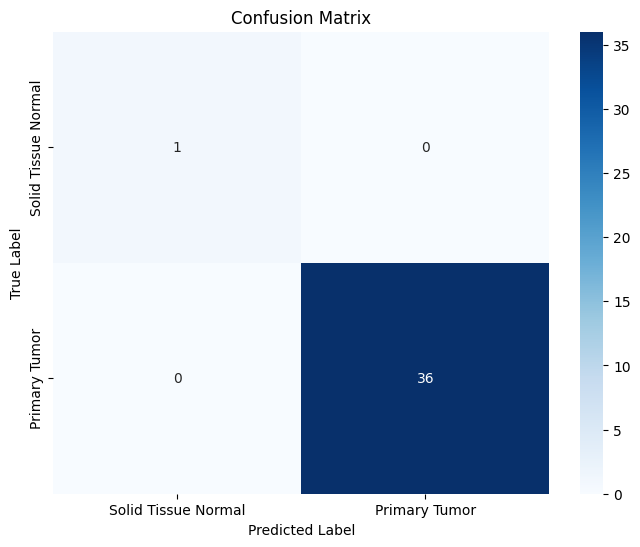

Classification Report-Validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        36

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Learning Rate: 0.0001, Best Accuracy: 100.0, Best Epoch: 3


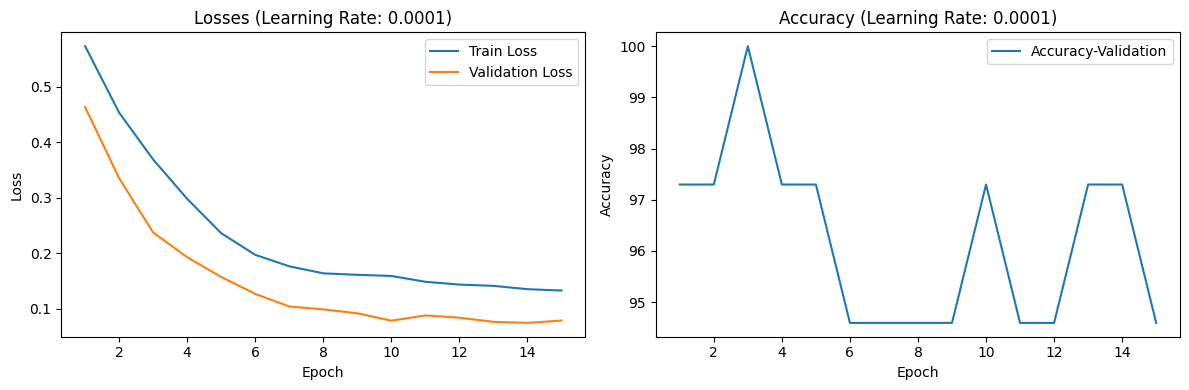


RESUTS FOR LEARNING RATE: 8e-05
Epoch [1], Train Loss: 0.6770, Validation Loss: 0.5971, Accuracy in Validation set: 100.00%
Epoch [2], Train Loss: 0.5833, Validation Loss: 0.4995, Accuracy in Validation set: 97.30%
Epoch [3], Train Loss: 0.5113, Validation Loss: 0.4073, Accuracy in Validation set: 97.30%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch [4], Train Loss: 0.4414, Validation Loss: 0.3206, Accuracy in Validation set: 97.30%
Epoch [5], Train Loss: 0.3717, Validation Loss: 0.2390, Accuracy in Validation set: 97.30%
Epoch [6], Train Loss: 0.2995, Validation Loss: 0.1893, Accuracy in Validation set: 97.30%
Epoch [7], Train Loss: 0.2385, Validation Loss: 0.1580, Accuracy in Validation set: 94.59%
Epoch [8], Train Loss: 0.2007, Validation Loss: 0.1299, Accuracy in Validation set: 94.59%
Epoch [9], Train Loss: 0.1800, Validation Loss: 0.1156, Accuracy in Validation set: 91.89%
Epoch [10], Train Loss: 0.1663, Validation Loss: 0.0988, Accuracy in Validation set: 94.59%
Epoch [11], Train Loss: 0.1601, Validation Loss: 0.0921, Accuracy in Validation set: 94.59%
Epoch [12], Train Loss: 0.1575, Validation Loss: 0.0865, Accuracy in Validation set: 94.59%
Epoch [13], Train Loss: 0.1512, Validation Loss: 0.0860, Accuracy in Validation set: 94.59%
Epoch [14], Train Loss: 0.1477, Validation Loss: 0.0844, Accuracy in Validation set: 9

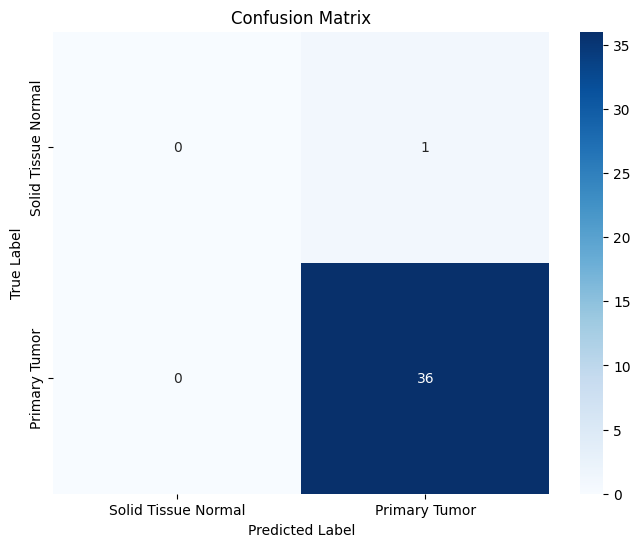

Classification Report-Validation:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.97      1.00      0.99        36

    accuracy                           0.97        37
   macro avg       0.49      0.50      0.49        37
weighted avg       0.95      0.97      0.96        37

Learning Rate: 8e-05, Best Accuracy: 97.29729729729729, Best Epoch: 2


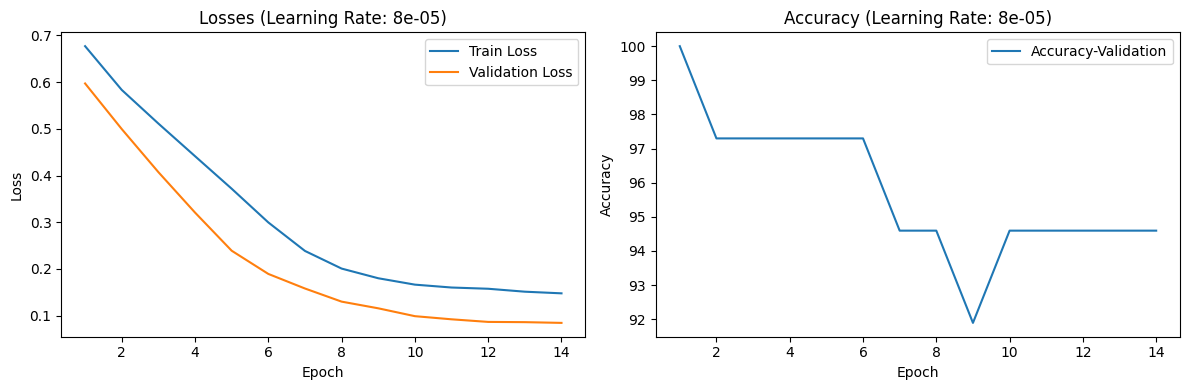


BEST SELECTED HYPERPARAMETERS:
Best Parameters: {'learning_rate': 0.0002, 'best_epoch': 3}, Best Accuracy: 100.0


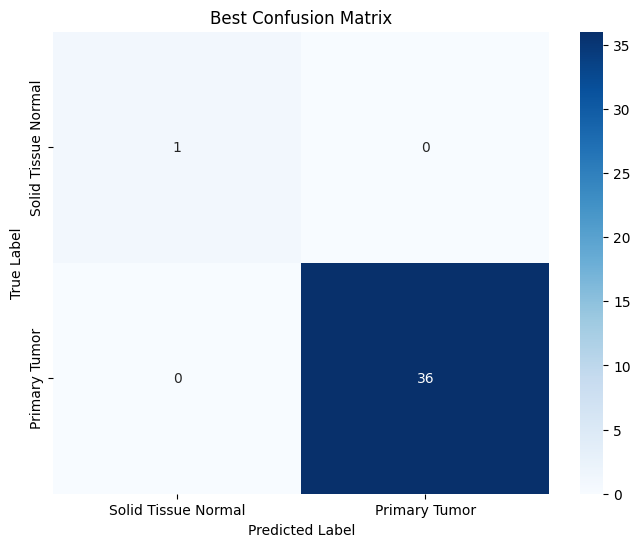

Best Classification Report-Validation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00        36

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



In [ ]:
# Grid search with early stopping for different learning rates:

# notes: with not augmented data with low learning rates, CNN learns too fast and it is inestable not showing a nice convergence of the losses.
#gets better by decreassing the learning rates

# Define the hyperparameter grid
#learning_rates_list = [ 0.1, 0.01, 0.008, 0.005, 0.002, 0.001, 0.0008]
#learning_rates_list = [0.0005, 0.0002, 0.0001]
learning_rates_list = [0.0002, 0.0001, 0.00008]

def plot_metrics(metrics_dict, learning_rate):
    epochs = range(1, len(metrics_dict['train_losses']) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics_dict['train_losses'], label='Train Loss')
    plt.plot(epochs, metrics_dict['test_losses'], label='Validation Loss')
    plt.title(f'Losses (Learning Rate: {learning_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics_dict['accuracies'], label='Accuracy-Validation')
    plt.title(f'Accuracy (Learning Rate: {learning_rate})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def grid_search(learning_rates_list, loaders_cnn, save_dir='/content'):
    best_accuracy = 0.0
    best_params = None
    best_confusion_matrix = None
    best_classification_report = None
    best_model_correct_info =None
    best_model_incorrect_info =None

    for learning_rate in learning_rates_list:
        print('RESUTS FOR LEARNING RATE:', learning_rate)

        model = CNN()

        results = train_and_evaluate_cnn_2(model, loaders_cnn, learning_rate)
        accuracy = results['best_accuracy']
        best_epoch = results['best_epoch']
        confusion_matrices = results['confusion_matrices']
        classification_reports = results['classification_reports']

        best_correct_info = results['Best_correct_info']
        best_incorrect_info = results['Best_incorrect_info']

        print(f'Learning Rate: {learning_rate}, Best Accuracy: {accuracy}, Best Epoch: {best_epoch}')

        # Plot losses and accuracies for each learning rate
        plot_metrics(results, learning_rate)

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_params = {'learning_rate': learning_rate, 'best_epoch': best_epoch}
            best_confusion_matrix = confusion_matrices[-1]
            best_classification_report = classification_reports[-1]

            best_model_correct_info = best_correct_info
            best_model_incorrect_info = best_incorrect_info

            # Save the model state temporarily in the /content directory
            model_save_name= 'Best_Model.pth'
            torch.save(model.state_dict(), model_save_name)

        print() # blank line
        # print("Next hyperparameters:")

    print('BEST SELECTED HYPERPARAMETERS:')
    print(f'Best Parameters: {best_params}, Best Accuracy: {best_accuracy}')

    # Print the best confusion matrix and classification report
    plt.figure(figsize=(8, 6))
    sns.heatmap(best_confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Best Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("Best Classification Report-Validation:")
    print(best_classification_report)

    return best_params, best_model_correct_info, best_model_incorrect_info

# Call grid_search function
best_params,best_model_correct_info, best_model_incorrect_info = grid_search(learning_rates_list, loaders_cnn)


In [ ]:
incorrect_info = best_model_incorrect_info
correct_info = best_model_correct_info

print(f'number of incorrect predictions : {len(incorrect_info)}'), print(f'number of correct predictions :{len(correct_info)}')

# Count the frequency of 1 and 0 in the second position (predicted values)
count_1 = sum(1 for prediction in incorrect_info if prediction[2] == 1)
count_0 = sum(1 for prediction in incorrect_info if prediction[2] == 0)

# Output the results
print("Frequency of Solid Tissue Normal (0) predicted wrongly as Primary Tumor (1):", count_1)
print("Frequency of  Primary Tumor(1) predicted wrongly as  Solid Tissue Normal (0):", count_0)

number of incorrect predictions : 0
number of correct predictions :37
Frequency of Solid Tissue Normal (0) predicted wrongly as Primary Tumor (1): 0
Frequency of  Primary Tumor(1) predicted wrongly as  Solid Tissue Normal (0): 0


In [ ]:
# saves indices of incorrect and correctly predited images
images_correct = [item[0] for item in correct_info]
images_incorrect = [item[0] for item in incorrect_info]
#print(images_incorrect)

# Plot the uncorrectly predicted images

for i, info in enumerate(incorrect_info):
    #print(i)
    #print(info)
    #print(f"Image number/index: {info[0]}")
    plt.figure(figsize=(3, 3))
    plt.imshow(info[1][0].numpy(), cmap='gray_r', aspect='auto')
    file_path = info[4]
    last_two_hierarchies = "/".join(file_path.split("/")[-2:])  # Assuming "/" is the path separator, extracts class and filename
    plt.title(f'Image for file {last_two_hierarchies}', fontsize= 10)
    plt.show()
    print(f"Image is (0=Normal, 1=Tumor): {info[3]}")
    print(f"Image was predicted as (0=Normal, 1=Tumor): {info[2]}")
    print("")
    print("")



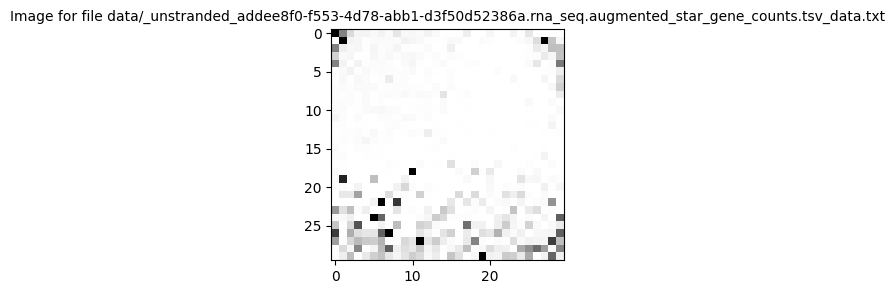

Image is (0=Normal, 1=Tumor): 1
Image was predicted as (0=Normal, 1=Tumor): 1.0




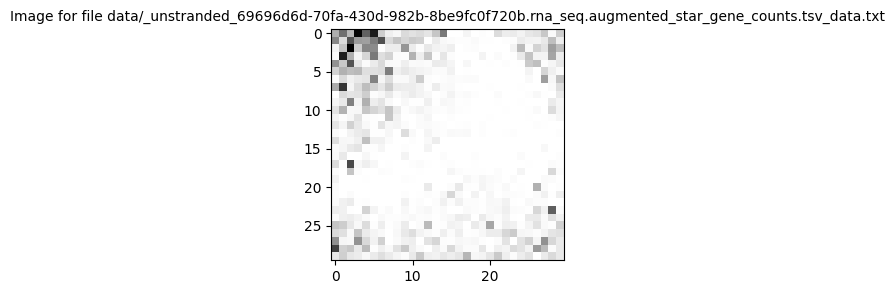

Image is (0=Normal, 1=Tumor): 1
Image was predicted as (0=Normal, 1=Tumor): 1.0




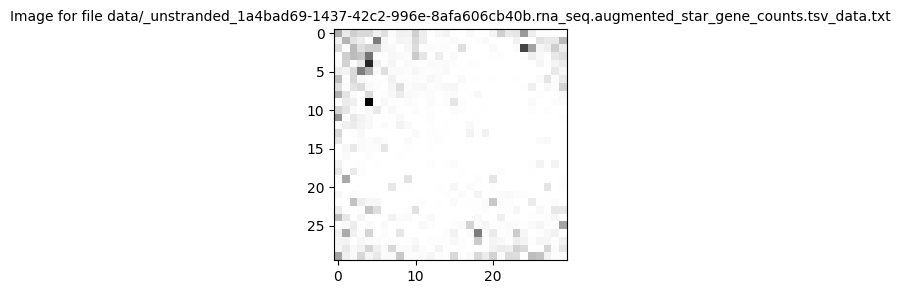

Image is (0=Normal, 1=Tumor): 1
Image was predicted as (0=Normal, 1=Tumor): 1.0




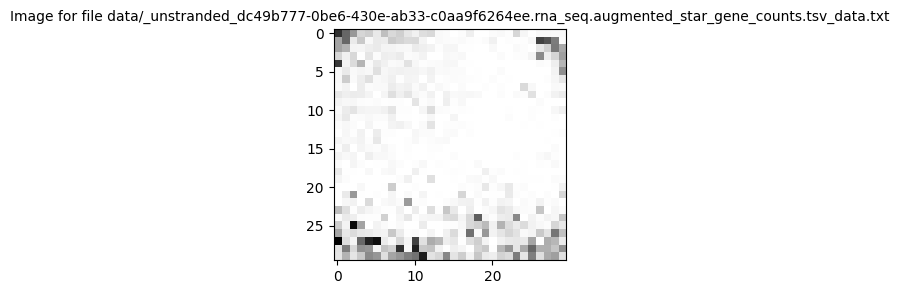

Image is (0=Normal, 1=Tumor): 1
Image was predicted as (0=Normal, 1=Tumor): 1.0




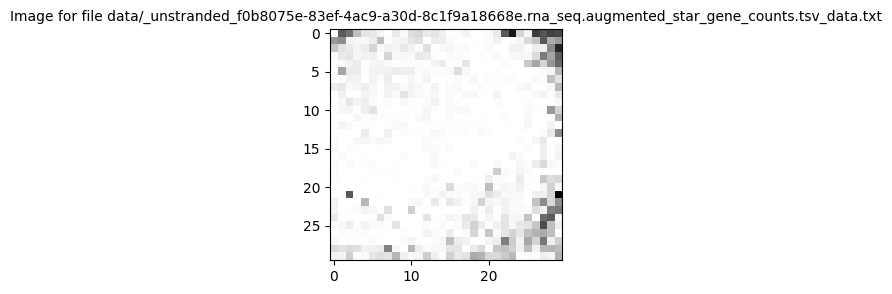

Image is (0=Normal, 1=Tumor): 1
Image was predicted as (0=Normal, 1=Tumor): 1.0




In [ ]:
# print few corrected images:

num_examples_to_display = 5  # Specify the number of examples to display

for i, info in enumerate(correct_info):
    if i >= num_examples_to_display:
        break  # Exit the loop after displaying the specified number of examples

    #print(i)
    #print(f"Image number/index: {info[0]}")
    plt.figure(figsize=(3, 3))
    plt.imshow(info[1][0].numpy(), cmap='gray_r', aspect='auto')
    file_path = info[4]
    last_two_hierarchies = "/".join(file_path.split("/")[-2:])  # Extracts class and filename from file path
    plt.title(f'Image for file {last_two_hierarchies}', fontsize=10)
    plt.show()
    print(f"Image is (0=Normal, 1=Tumor): {info[3]}")
    print(f"Image was predicted as (0=Normal, 1=Tumor): {info[2]}")
    print("")
    print("")

#Inference with 10% of the data if we split the data and save for evaluation


In [ ]:
# Check the shape of the first batch in the val loader
for images_tensor, labels_tensor, file_paths in loaders_cnn['validation']:
    print("Images shape (first batch in validation loader):", images_tensor.shape)
    print("Labels shape (test loader):", labels_tensor.shape)
    print("File paths (first batch in validation loader):", file_paths)
    break  # Break after printing the first batch to avoid printing for every batch



Images shape (first batch in validation loader): torch.Size([32, 1, 30, 30])
Labels shape (test loader): torch.Size([32])
File paths (first batch in validation loader): ('/content/data/data/_unstranded_a20170ce-5dd8-47e4-bdba-741cf08a1144.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_ff4284af-295f-407a-ae37-dbc7da985591.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_b05e342c-7c99-4ce4-8f5c-19dc88bc516a.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_1c37eeeb-2667-4def-840d-74d7b143d413.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_5fa8a559-e1f3-4602-a4ca-974b41b0b50b.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_55b84289-acf0-4385-8b69-e5bd597130ae.rna_seq.augmented_star_gene_counts.tsv_data.txt', '/content/data/data/_unstranded_fd634fc1-ecd0-4e31-8410-64f0a26fb050.rna_seq.augmented_star_gene_counts.tsv_data.txt

97.14285714285714
Confusion Matrix:
[[ 3  0]
 [ 1 31]]


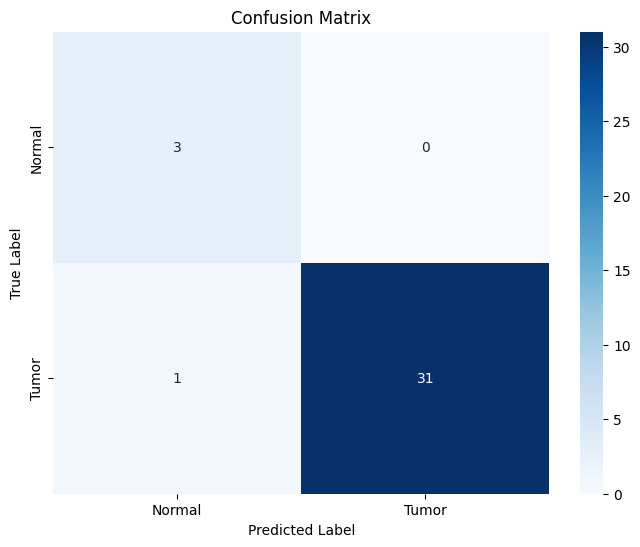


Classification Report Test (Unseen data):
              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       1.00      0.97      0.98        32

    accuracy                           0.97        35
   macro avg       0.88      0.98      0.92        35
weighted avg       0.98      0.97      0.97        35



In [ ]:
# call the model and evaluate:

# load the best model and evaluate the validation images

def inference(cnn, loaders_cnn):
    # Load the pre-trained model

    cnn.load_state_dict(torch.load("/content/Best_Model.pth"))
    cnn.eval()  # Set the model to evaluation model

    correct = 0
    total = 0

    correct_info = [] # appended data for all batches in this epoch
    incorrect_info = []

    y_true_epoch = []
    y_pred_epoch = []

    with torch.no_grad():
          for images, labels, file_paths in loaders_cnn['validation']:
              outputs = cnn(images, loaders_cnn)
              outputs = outputs.squeeze(dim=1)


              predicted = torch.round(outputs)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()

              # append true and predicted labels for each batch
              y_true_epoch.extend(labels.tolist())
              y_pred_epoch.extend(predicted.tolist())

              # Check for correct and incorrect predictions, tuples containing the indexes, the images, predicted and true labels and images paths.
              correct_mask = predicted == labels
              cumulative_batch_size = labels.size(0) * i

              correct_info.extend([(cumulative_batch_size + j, images[j], predicted[j].item(), labels[j].item(), file_paths[j]) for j, is_correct in enumerate(correct_mask) if is_correct])
              incorrect_info.extend([(cumulative_batch_size + j, images[j], predicted[j].item(), labels[j].item(), file_paths[j]) for j, is_correct in enumerate(correct_mask) if not is_correct])


    accuracy = 100 * correct / total
    print(accuracy)

    # Print confusion matrix and classification report
    print("Confusion Matrix:")
    print(confusion_matrix(y_true_epoch, y_pred_epoch))

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true_epoch, y_pred_epoch), annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Tumor"], yticklabels=["Normal", "Tumor"])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    print("\nClassification Report Test (Unseen data):")
    print(classification_report(y_true_epoch, y_pred_epoch))

    return incorrect_info

cnn = CNN()  # Initiate your CNN model, make sure the cnn from where the model is saved is the last run
incorrect_info = inference(cnn, loaders_cnn)

/content/data/data/_unstranded_3a8026d4-4092-44d1-9ab9-55d6e47b3bfa.rna_seq.augmented_star_gene_counts.tsv_data.txt


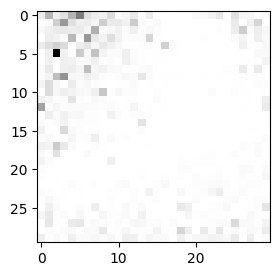

Image is (0=Normal, 1=Tumor): 1
Image was predicted as (0=Normal, 1=Tumor): 0.0




In [ ]:
# plot few incorrect images:

# saves indices of incorrect and correctly predited images
images_incorrect = [item[0] for item in incorrect_info]
#print(images_incorrect)

# Plot the uncorrectly predicted images

for i, info in enumerate(incorrect_info):
    plt.figure(figsize=(3, 3))
    plt.imshow(info[1][0].numpy(), cmap='gray_r', aspect='auto')
    file_path = info[4]
    print(file_path)
    plt.show()
    print(f"Image is (0=Normal, 1=Tumor): {info[3]}")
    print(f"Image was predicted as (0=Normal, 1=Tumor): {info[2]}")
    print("")
    print("")

